In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn
from copy import deepcopy

df = pd.read_csv('pricerunner_aggregate.csv')

df.columns = ['ID', 'Title', 'VendorID', 'ClusterID', 'ClusterLabel', 'CategoryID', 'CategoryLabel']

df.drop(['ID','Title','VendorID','ClusterID','CategoryID','CategoryLabel'],axis=1,inplace=True)

In [3]:
path = 'english-adjectives.txt'
file = open(path, 'r')

adjectives = set()

for line in file:
    adjectives.add(line[:-1])

file.close()

adjectives.add('stainless')
adjectives.add('integrated')
adjectives.remove('sharp')

In [4]:
def eliminate_adjectives(df2, column_name):
    df = deepcopy(df2)

    def remove_adjectives(row):
        words_list = row[column_name].split()
        words_list2 = [word for word in words_list if word.lower() not in adjectives]
        if len(words_list2) == 0:
            return 'null'
        else:
            return ' '.join(words_list2)

    df[column_name] = df.apply(remove_adjectives, axis=1)
    return df


df = eliminate_adjectives(df, 'ClusterLabel')

In [5]:
def eliminate_number_words(df2, column_name):
    df = deepcopy(df2)
    numbers = {'1', '2', '3', '4', '5', '6', '7', '8', '9'}
    
    def remove_number_words(row):
        words_list = row.split()
        words_list2 = [word for word in words_list if not any(char.isdigit() for char in word)]

        if len(words_list2) == 0:
            return 'null'
        else:
            return ' '.join(words_list2)

    df[column_name] = df[column_name].apply(remove_number_words)
    return df


df = eliminate_number_words(df, 'ClusterLabel')

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word')

X = vectorizer.fit_transform(df['ClusterLabel'])

df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [7]:
# from sklearn.cluster import KMeans
# def count_wcss_scores(X, k_max):
#     #  WCSS = within-cluster sum of squares
#     scores = []
#     for k in range(1, k_max+1):
#         kmeans = KMeans(n_clusters=k, random_state=0)
#         kmeans.fit(X)
#         wcss = kmeans.score(X) * -1 # score returns -WCSS
#         scores.append(wcss)
#     return scores

# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt


# wcss_vec = count_wcss_scores(df_tfidf, 30)
# x_ticks = list(range(1, len(wcss_vec) + 1))
# plt.plot(x_ticks, wcss_vec, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Within-cluster sum of squares')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [30]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
result = pd.concat([df['ClusterLabel'],pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())],axis=1)
result['cluster'] = kmeans.predict(X)

c:\Users\mateu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [31]:
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='Name' and x!='cluster' and x != 'ClusterLabel' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')


In [13]:
print('value_counts: \n', result_labelled.groupby(['label'])['label'].count().sort_values(ascending=False))

labels = result_labelled.groupby(['label'])['label'].count().sort_values(ascending=False).index.tolist()

print('\n\nnumber of labels: \n', len(labels))
print('\n\nlabels: ', labels)

value_counts: 
 label
bosch                            3261
samsung                          1928
siemens                          1759
smeg                             1179
lg                               1112
                                 ... 
ebac                               12
logik                              12
finlux                             11
ide kfn miele                       9
biofresh kbp liebherr premium       2
Name: label, Length: 191, dtype: int64


number of labels: 
 191


labels:  ['bosch', 'samsung', 'siemens', 'smeg', 'lg', 'hotpoint', '', 'aeg', 'beko', 'neff', 'zanussi', 'liebherr', 'indesit', 'gorenje', 'intel xeon', 'hoover', 'box core intel', 'miele', 'bravia sony', 'galaxy samsung', 'sim', 'whirlpool', 'hobbs russell', 'hisense', 'candy', 'box', 'core intel', 'panasonic', 'lumix panasonic', 'apple iphone', 'blomberg', 'lec', 'opteron socket tray', 'sharp', 'nokia', 'tray xeon', 'canon eos is', 'comfort', 'cda', 'montpellier', 'philips', 'sony xperi

<Axes: title={'center': 'Liczba elementów w stworzonych labels'}, xlabel='label'>

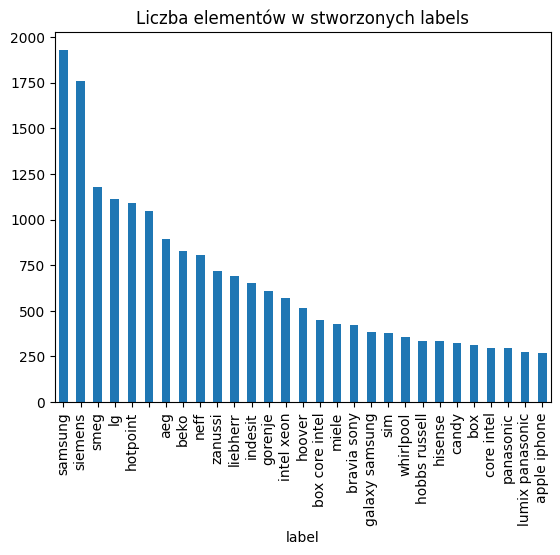

In [11]:
p = result_labelled['label'].value_counts().sort_values(ascending=False).head(30).tail(29)
p.plot(kind='bar',title='Liczba elementów w stworzonych labels')

In [29]:
#Visualise sizes of supermarket categories (manually added to result_labelled) and clean clusters
result_summary = pd.pivot_table(result_labelled,index=['label','cluster'],values=['ClusterLabel'],aggfunc='count').reset_index().rename(columns={'ClusterLabel':'count'})
result_treemap = result_summary[(result_summary['label'] != '') & (result_summary['count'] > 1)]
fig = px.treemap(result_treemap,path=['cluster','label'],values='count')
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'branchvalues': 'total',
              'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
              'hovertemplate': 'labels=%{label}<br>count=%{value}<br>parent=%{parent}<br>id=%{id}<extra></extra>',
              'ids': array(['21/aeg', '99/akai', '72/alcatel', ..., '197', '198', '199'],
                           dtype=object),
              'labels': array(['aeg', 'akai', 'alcatel', ..., '197', '198', '199'], dtype=object),
              'name': '',
              'parents': array(['21', '99', '72', ..., '', '', ''], dtype=object),
              'type': 'treemap',
              'values': array([892,  32, 100, ...,  43,  24,  76], dtype=int64)}],
    'layout': {'legend': {'tracegroupgap': 0}, 'margin': {'t': 60}, 'template': '...'}
})